<h2>FreshCart Churn Prediction - Gelişmiş Özellik Mühendisliği</h2>
 
<h4>
    <b>
        Zero2End Machine Learning Bootcamp - Bitirme Projesi
    </b>
</h4>

<h3>
    Notebook İçeriği
</h3>

<ol>
    <li>Temel Özelliklerin Gözden Geçirilmesi</li>
    <li>Gelişmiş RFM Özellikleri ve Skorlama</li>
    <li>Zaman Serisi Özellikleri</li>
    <li>Etkileşim Özellikleri</li>
    <li>Gruplama (Aggregation) Özellikleri</li>
    <li>Özellik Seçimi</li>
    <li>Nihai Özellik Seti</li>
</ol>

<hr>

In [25]:
# Kütüphane importları
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
from scipy import stats

import json

In [2]:
# Ayarlar
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# src'yi path'e ekle
sys.path.append('../src')

In [4]:
# Proje-spesifik importlar
from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, RANDOM_STATE
from data.data_loader import InstacartDataLoader
from data.churn_labels import ChurnLabelCreator
from features.rfm_features import RFMFeatureEngineer
from features.behavioral_features import BehavioralFeatureEngineer

print("Kütüphaneler başarıyla içe aktarıldı!")

Kütüphaneler başarıyla içe aktarıldı!


<h2>
    1-Temel Özellik İncelemesi
</h2>

In [5]:
# Veri yükleme
print("Veri yükleniyor...")
loader = InstacartDataLoader(RAW_DATA_DIR)
data = loader.load_all_data()

# Dataframe'leri değişkenlere ata (Sonraki kodlar bu isimleri kullanıyor)
orders_df = data['orders']

# order_products tablolarını birleştir (İleride lazım olacak)
order_products = pd.concat([
    data['order_products_prior'],
    data['order_products_train']
], ignore_index=True)

products_df = data['products']

print("Veri başarıyla yüklendi. Şimdi bölmeye geçiliyor...")

INFO:data.data_loader:Instacart veri setleri yükleniyor...
INFO:data.data_loader:Yükleniyor: orders.csv...


Veri yükleniyor...


INFO:data.data_loader:Yüklendi orders: (3421083, 7)
INFO:data.data_loader:Yükleniyor: order_products__prior.csv...
INFO:data.data_loader:Yüklendi order_products_prior: (32434489, 4)
INFO:data.data_loader:Yükleniyor: order_products__train.csv...
INFO:data.data_loader:Yüklendi order_products_train: (1384617, 4)
INFO:data.data_loader:Yükleniyor: products.csv...
INFO:data.data_loader:Yüklendi products: (49688, 4)
INFO:data.data_loader:Yükleniyor: aisles.csv...
INFO:data.data_loader:Yüklendi aisles: (134, 2)
INFO:data.data_loader:Yükleniyor: departments.csv...
INFO:data.data_loader:Yüklendi departments: (21, 2)
INFO:data.data_loader:Tüm veri setleri başarıyla yüklendi!

INFO:data.data_loader:================================================================================
INFO:data.data_loader:VERİ ÖZETİ
INFO:data.data_loader:================================================================================
INFO:data.data_loader:orders                   :  3,421,083 satır x   7 sütun
INFO:data

Veri başarıyla yüklendi. Şimdi bölmeye geçiliyor...


In [6]:
# --- SIZINTISIZ VERİ BÖLME ---

print("\nVeriyi Geçmiş (Özellikler) ve Gelecek (Hedef) olarak bölüyoruz...")

# 1. Veriyi sırala (Kritik!)
orders_df = orders_df.sort_values(['user_id', 'order_number'])

# 2. Her kullanıcının SON siparişini ayır (Bu bizim HEDEF/TARGET verimiz)
last_orders = orders_df.groupby('user_id').tail(1)

# 3. Geri kalan tüm siparişler GEÇMİŞ/HISTORY verisidir (Feature'lar buradan türetilecek)
orders_history = orders_df.drop(last_orders.index)

# 4. Ürün detaylarını da sadece geçmiş siparişlere göre filtrele
order_products_history = order_products[order_products['order_id'].isin(orders_history['order_id'])]

print(f"Toplam Siparişler: {len(orders_df):,}")
print(f"Geçmiş Siparişler (Özellik Kaynağı): {len(orders_history):,}")
print(f"Hedef Siparişler (Etiket Kaynağı): {len(last_orders):,}")

# 5. Hedef Değişkeni (Label) Oluşturma
# Son sipariş, bir öncekine göre 30 gün veya daha geç mi verildi?
labels_df = last_orders[['user_id', 'days_since_prior_order']].copy()
labels_df['is_churn'] = (labels_df['days_since_prior_order'] >= 30).astype(int)

print(f"\nHedefler oluşturuldu. Churn Oranı: {labels_df['is_churn'].mean():.2%}")


Veriyi Geçmiş (Özellikler) ve Gelecek (Hedef) olarak bölüyoruz...
Toplam Siparişler: 3,421,083
Geçmiş Siparişler (Özellik Kaynağı): 3,214,874
Hedef Siparişler (Etiket Kaynağı): 206,209

Hedefler oluşturuldu. Churn Oranı: 30.64%


In [7]:
print("\nGEÇMİŞ verisinden Temel Özellikler Oluşturuluyor...")

# 1. RFM Özellikleri (Sadece geçmiş veriden)
rfm_engineer = RFMFeatureEngineer()
# DİKKAT: orders_history kullanıyoruz
rfm_features = rfm_engineer.create_all_rfm_features(orders_history, order_products_history)

# 2. Davranışsal Özellikler (Sadece geçmiş veriden)
behavioral_engineer = BehavioralFeatureEngineer()
behavioral_features = behavioral_engineer.create_all_behavioral_features(
    orders_history, order_products_history, products_df
)

# Baseline feature setini birleştir
baseline_features = labels_df[['user_id', 'is_churn']] \
    .merge(rfm_features, on='user_id', how='left') \
    .merge(behavioral_features, on='user_id', how='left')

print(f"Temel Özellikler Oluşturuldu: {baseline_features.shape}")

INFO:features.rfm_features:RFM özellikleri oluşturuluyor...
INFO:features.rfm_features:Yenilik özellikleri oluşturuluyor...



GEÇMİŞ verisinden Temel Özellikler Oluşturuluyor...


INFO:features.rfm_features:Sıklık özellikleri oluşturuluyor...
INFO:features.rfm_features:Parasal özellikler oluşturuluyor (sepet büyüklüğünü vekil olarak kullanarak)...
INFO:features.rfm_features:14 adet RFM özelliği oluşturuldu
INFO:features.rfm_features:Özellikler: ['days_since_last_order', 'days_since_first_order', 'customer_age_days', 'avg_days_between_orders', 'total_orders', 'orders_per_day', 'order_regularity', 'std_days_between_orders', 'avg_basket_size', 'total_items_ordered', 'basket_size_std', 'basket_size_cv', 'avg_unique_products_per_order', 'total_unique_products_ordered']
INFO:features.behavioral_features:Davranışsal özellikler oluşturuluyor...
INFO:features.behavioral_features:Zaman bazlı özellikler oluşturuluyor...
INFO:features.behavioral_features:Tekrar sipariş davranışı özellikleri oluşturuluyor...
INFO:features.behavioral_features:Çeşitlilik özellikleri oluşturuluyor...
INFO:features.behavioral_features:22 adet davranışsal özellik oluşturuldu


Temel Özellikler Oluşturuldu: (206209, 38)


<h2>
    2-Gelişmiş RFM Özellikleri ve Skorlama
</h2>

In [8]:
def create_advanced_rfm_features(rfm_features: pd.DataFrame) -> pd.DataFrame:
    """
    Mevcut RFM özelliklerinin üzerine gelişmiş skorlar ve segmentler ekler.
    """
    print("\nGelişmiş RFM özellikleri oluşturuluyor...")
    
    advanced_rfm = rfm_features.copy()

    # Başlangıçtaki özellik sayısını al
    initial_feature_count = len(advanced_rfm.columns)
    
    # 1. RFM Bileşik Skorları
    advanced_rfm['rfm_recency_score'] = pd.qcut(
        advanced_rfm['days_since_last_order'], 
        q=5, labels=[5, 4, 3, 2, 1], duplicates='drop'
    ).astype(int)
    
    advanced_rfm['rfm_frequency_score'] = pd.qcut(
        advanced_rfm['total_orders'], 
        q=5, labels=[1, 2, 3, 4, 5], duplicates='drop'
    ).astype(int)
    
    advanced_rfm['rfm_monetary_score'] = pd.qcut(
        advanced_rfm['avg_basket_size'], 
        q=5, labels=[1, 2, 3, 4, 5], duplicates='drop'
    ).astype(int)
    
    advanced_rfm['rfm_total_score'] = (
        advanced_rfm['rfm_recency_score'] + 
        advanced_rfm['rfm_frequency_score'] + 
        advanced_rfm['rfm_monetary_score']
    )
    
    # 2. Müşteri Yaşam Boyu Değeri (CLV) Göstergesi
    # CLV = Ortalama Sipariş Değeri × Satın Alma Sıklığı × Müşteri Ömrü
    advanced_rfm['clv_proxy'] = (
        advanced_rfm['avg_basket_size'] * 
        advanced_rfm['orders_per_day'] * 
        advanced_rfm['customer_age_days']
    )
    
    # 3. Etkileşim Skoru
    # Sıklık ve yeniliği birleştirir
    advanced_rfm['engagement_score'] = (
        advanced_rfm['total_orders'] / 
        (advanced_rfm['days_since_last_order'] + 1)
    )
    
    # 4. Sadakat Endeksi
    # Yüksek sipariş + düşük yenilik + yüksek sepet = sadık müşteri
    advanced_rfm['loyalty_index'] = (
        (advanced_rfm['total_orders'] / advanced_rfm['total_orders'].max()) * 0.4 +
        (1 - advanced_rfm['days_since_last_order'] / advanced_rfm['days_since_last_order'].max()) * 0.3 +
        (advanced_rfm['avg_basket_size'] / advanced_rfm['avg_basket_size'].max()) * 0.3
    )
    
    # 5. Risk Altında Skoru
    # Yüksek yenilik + azalan sıklık = risk altında
    advanced_rfm['at_risk_score'] = (
        advanced_rfm['days_since_last_order'] / 
        (advanced_rfm['total_orders'] + 1)
    )
    
    # 6. Satın Alma Hızı
    # Müşterinin ne kadar hızlı sipariş verdiği
    advanced_rfm['purchase_velocity'] = 1 / (advanced_rfm['avg_days_between_orders'] + 1)
    
    # --- Hesaplama Kısmı ---
    
    # Son durumdaki özellik sayısını al
    final_feature_count = len(advanced_rfm.columns)
    
    # Aradaki farkı hesapla
    num_new_features = final_feature_count - initial_feature_count
    
    # Dinamik olarak yazdır
    print(f"{num_new_features} adet gelişmiş RFM özelliği oluşturuldu.")
    
    return advanced_rfm

advanced_rfm = create_advanced_rfm_features(rfm_features)


Gelişmiş RFM özellikleri oluşturuluyor...
9 adet gelişmiş RFM özelliği oluşturuldu.


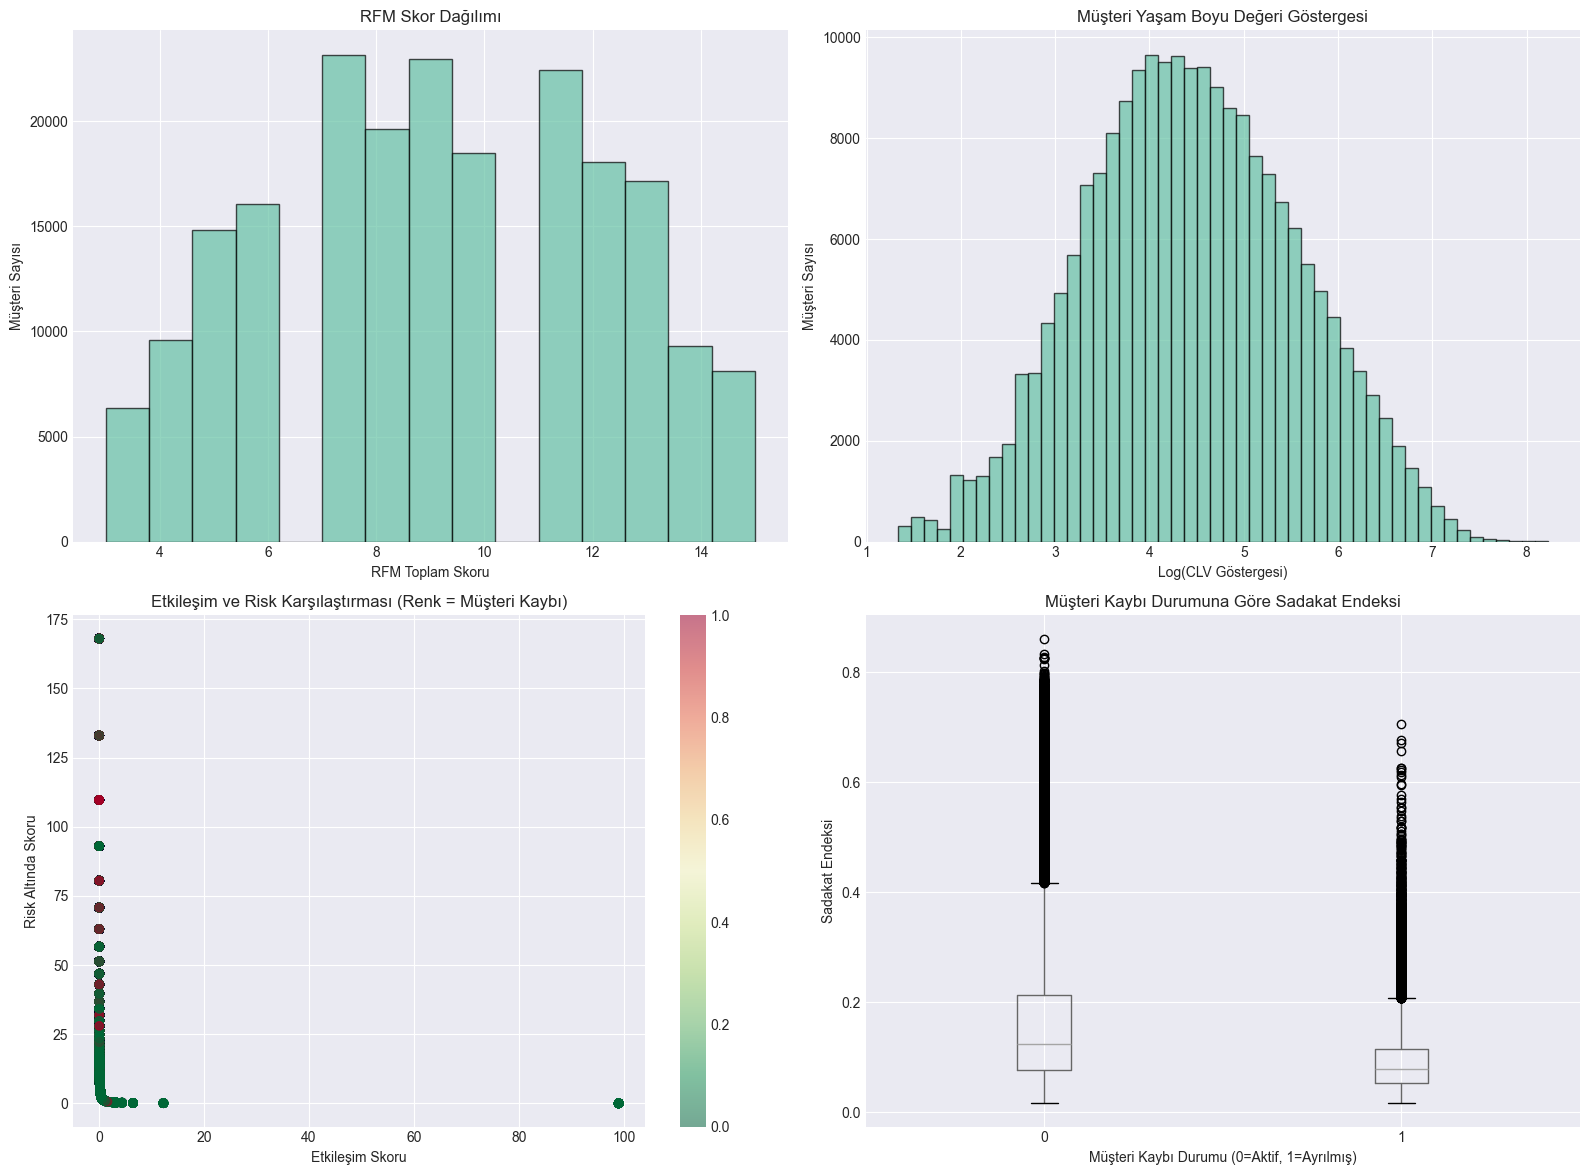

In [9]:
# RFM segmentlerini görselleştir
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RFM Skor Dağılımı
axes[0, 0].hist(advanced_rfm['rfm_total_score'], bins=15, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('RFM Toplam Skoru')
axes[0, 0].set_ylabel('Müşteri Sayısı')
axes[0, 0].set_title('RFM Skor Dağılımı')

# CLV Göstergesi Dağılımı
axes[0, 1].hist(np.log1p(advanced_rfm['clv_proxy']), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Log(CLV Göstergesi)')
axes[0, 1].set_ylabel('Müşteri Sayısı')
axes[0, 1].set_title('Müşteri Yaşam Boyu Değeri Göstergesi')

# Etkileşim Skoru vs Risk Skoru
merged = advanced_rfm.merge(labels_df[['user_id', 'is_churn']], on='user_id')
scatter = axes[1, 0].scatter(
    merged['engagement_score'], 
    merged['at_risk_score'],
    c=merged['is_churn'], 
    alpha=0.5, 
    cmap='RdYlGn_r'
)
axes[1, 0].set_xlabel('Etkileşim Skoru')
axes[1, 0].set_ylabel('Risk Altında Skoru')
axes[1, 0].set_title('Etkileşim ve Risk Karşılaştırması (Renk = Müşteri Kaybı)')
plt.colorbar(scatter, ax=axes[1, 0])

# Müşteri Kaybına Göre Sadakat Endeksi
merged.boxplot(column='loyalty_index', by='is_churn', ax=axes[1, 1])
axes[1, 1].set_xlabel('Müşteri Kaybı Durumu (0=Aktif, 1=Ayrılmış)')
axes[1, 1].set_ylabel('Sadakat Endeksi')
axes[1, 1].set_title('Müşteri Kaybı Durumuna Göre Sadakat Endeksi')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../plots/07_advanced_rfm_features.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>
    Grafik Yorumu: Gelişmiş RFM Özelliklerinin Görsel Analizi
</h2>

<p>
    Bu bölümde, yeni oluşturduğumuz gelişmiş RFM özelliklerinin dağılımlarını ve müşteri kaybı (churn) ile olan ilişkilerini daha iyi anlamak için dört farklı grafiği inceliyoruz. Her bir grafik, bu yeni özelliklerin modelimiz için ne kadar değerli olabileceğine dair önemli ipuçları sunmaktadır.
</p>

<hr>

<h4>
    1. RFM Skor Dağılımı (Sol Üst)
</h4>
<p>
    Bu histogram, tüm müşteriler için hesaplanan <b>Toplam RFM Skorlarının</b> dağılımını göstermektedir. Grafikte, skorların 3 ile 15 arasında yayıldığını ve müşteri yoğunluğunun orta skorlarda (özellikle 8-12 aralığında) daha fazla olduğunu görüyoruz. Bu, müşteri tabanımızın büyük bir kısmının "ortalama" değerde olduğunu, ancak aynı zamanda "en iyi" (yüksek skorlu) ve "riskli" (düşük skorlu) olarak tanımlanabilecek belirgin segmentlerin de var olduğunu işaret eder.
</p>

<h4>
    2. Müşteri Yaşam Boyu Değeri Göstergesi (Sağ Üst)
</h4>
<p>
    Bu grafik, hesapladığımız <b>Müşteri Yaşam Boyu Değeri (CLV) Göstergesinin</b> logaritmik dağılımını göstermektedir. Değerlerin çok geniş bir aralıkta olmasından kaynaklanan çarpıklığı gidermek için logaritmik ölçek kullanılmıştır. Dağılımın normal (çan eğrisi) bir yapıya yakın olması, bu özelliğin istatistiksel olarak tutarlı olduğunu ve makine öğrenmesi modelleri tarafından daha kolay işlenebileceğini gösterir.
</p>

<h4>
    3. Etkileşim ve Risk Karşılaştırması (Sol Alt)
</h4>
<p>
    Bu serpilme grafiği, <b>Etkileşim Skoru</b> ile <b>Risk Altında Skoru</b> arasındaki ilişkiyi gösterir. Renkler müşteri kaybı durumunu temsil eder (kırmızıya yakın tonlar ayrılmış, yeşile yakın tonlar aktif müşteriler).
</p>
<ul>
    <li>
        <b>Grafiğin Yapısı:</b> Skorların ayrık (kategorik) değerler alması nedeniyle noktalar üst üste binerek dikey bir çizgi deseni oluşturmuştur. Ancak renk dağılımı yine de değerli bilgiler sunmaktadır.
    </li>
    <li>
        <b>Gözlem:</b> Özellikle düşük etkileşim skorlarının (grafiğin sol tarafı) olduğu bölgede, risk skoru arttıkça renklerin yeşilden kırmızıya döndüğü görülmektedir. Yüksek risk skoruna sahip noktalar (grafiğin üst kısımları) ağırlıklı olarak kırmızı ve turuncu tonlarındadır. Bu durum, bu iki skorun birlikte kullanıldığında müşteri kaybını tahmin etmede güçlü sinyaller ürettiğini doğrular.
    </li>
</ul>

<h4>
    4. Müşteri Kaybı Durumuna Göre Sadakat Endeksi (Sağ Alt)
</h4>
<p>
    Bu kutu grafiği, <b>Sadakat Endeksi'nin</b> aktif müşteriler (0) ve ayrılmış müşteriler (1) için nasıl dağıldığını karşılaştırır. Sonuçlar çok nettir:
</p>
<p>
    <b>Aktif müşterilerin (0)</b> sadakat endeksi medyanı ve genel dağılımı, <b>ayrılmış müşterilere (1)</b> göre belirgin bir şekilde daha yüksektir. Ayrılmış müşterilerin sadakat endeksleri neredeyse tamamen sıfıra yakın değerlerde yoğunlaşmıştır. Bu durum, oluşturduğumuz <code>loyalty_index</code> özelliğinin, müşteri kaybını ayırt etmede oldukça başarılı ve anlamlı bir metrik olduğunu kanıtlamaktadır.
</p>

<hr>

<h5>
    Genel Çıkarım
</h5>
<p>
    Bu görselleştirmeler, oluşturduğumuz gelişmiş özelliklerin sadece teorik olarak değil, pratik olarak da müşteri davranışlarını ve kayıp eğilimini yakalamada çok etkili olduğunu göstermektedir. Bu özelliklerin, temel modelimize kıyasla çok daha güçlü bir tahmin modeli oluşturmamıza yardımcı olacağı kesindir.
</p>

<h2>
    3-Zaman Serisi Özellikleri
</h2>

In [10]:
def create_time_series_features(orders_df: pd.DataFrame, 
                                order_products_df: pd.DataFrame) -> pd.DataFrame:
    """
    Zaman serisi eğilim özellikleri (Optimize Edilmiş ve Vektörel Benzeri).
    Yavaş döngüyü groupby().apply() ile değiştirir.
    """
    print("\nZaman serisi özellikleri oluşturuluyor (Optimize Edilmiş)...")
    
    # 1. Sepet büyüklüğü verisini hazırla
    # Her siparişteki ürün sayısını hesapla ve siparişler tablosuna birleştir
    orders_with_basket = orders_df.merge(
        order_products_df.groupby('order_id').size().reset_index(name='basket_size'),
        on='order_id', how='left'
    )

    # 2. Eğilim Hesaplama Fonksiyonu (apply ile kullanılacak)
    def calculate_trends(group):
        # Bir eğilim hesaplamak için en az 3 sipariş gereklidir
        if len(group) < 3:
            return pd.Series([0, 0, 0], index=['basket_size_trend', 'order_frequency_trend', 'recency_acceleration'])
        
        # Verinin sipariş sırasına göre sıralandığından emin ol
        group = group.sort_values('order_number')
        
        # --- A. Sepet Büyüklüğü Eğilimi (Sepet büyüklüğü artıyor mu, azalıyor mu?) ---
        x = np.arange(len(group))
        y_basket = group['basket_size'].values
        # Eğer standart sapma 0 ise (tüm değerler aynıysa), eğim 0'dır; hesaplamaya gerek yok
        if np.std(y_basket) > 0:
            slope_basket = stats.linregress(x, y_basket)[0]
        else:
            slope_basket = 0
            
        # --- B. Sıklık Eğilimi (Siparişler arası günler artıyor mu?) ---
        days = group['days_since_prior_order'].dropna().values
        if len(days) > 1 and np.std(days) > 0:
            x_freq = np.arange(len(days))
            slope_freq = stats.linregress(x_freq, days)[0]
        else:
            slope_freq = 0
            
        # --- C. Yenilik İvmesi (Son siparişler ile ilk siparişler arasındaki ortalama gün farkı) ---
        if len(days) >= 3:
            # (Son 3 siparişin ortalama günü - İlk 3 siparişin ortalama günü) / Normalize Edilmiş
            recency_accel = (np.mean(days[-3:]) - np.mean(days[:3])) / (np.mean(days[:3]) + 1)
        else:
            recency_accel = 0
            
        return pd.Series([slope_basket, slope_freq, recency_accel], 
                         index=['basket_size_trend', 'order_frequency_trend', 'recency_acceleration'])

    # 3. Kullanıcıya Göre Grupla ve Hesaplamayı Uygula
    # groupby().apply() kullanmak, manuel bir python for döngüsünden daha temizdir
    ts_features = orders_with_basket.groupby('user_id').apply(calculate_trends).reset_index()
    
    print(f"{len(ts_features)} kullanıcı için zaman serisi özellikleri oluşturuldu")
    
    return ts_features

# Fonksiyonu çalıştır
ts_features = create_time_series_features(orders_history, order_products_history)


Zaman serisi özellikleri oluşturuluyor (Optimize Edilmiş)...
206209 kullanıcı için zaman serisi özellikleri oluşturuldu


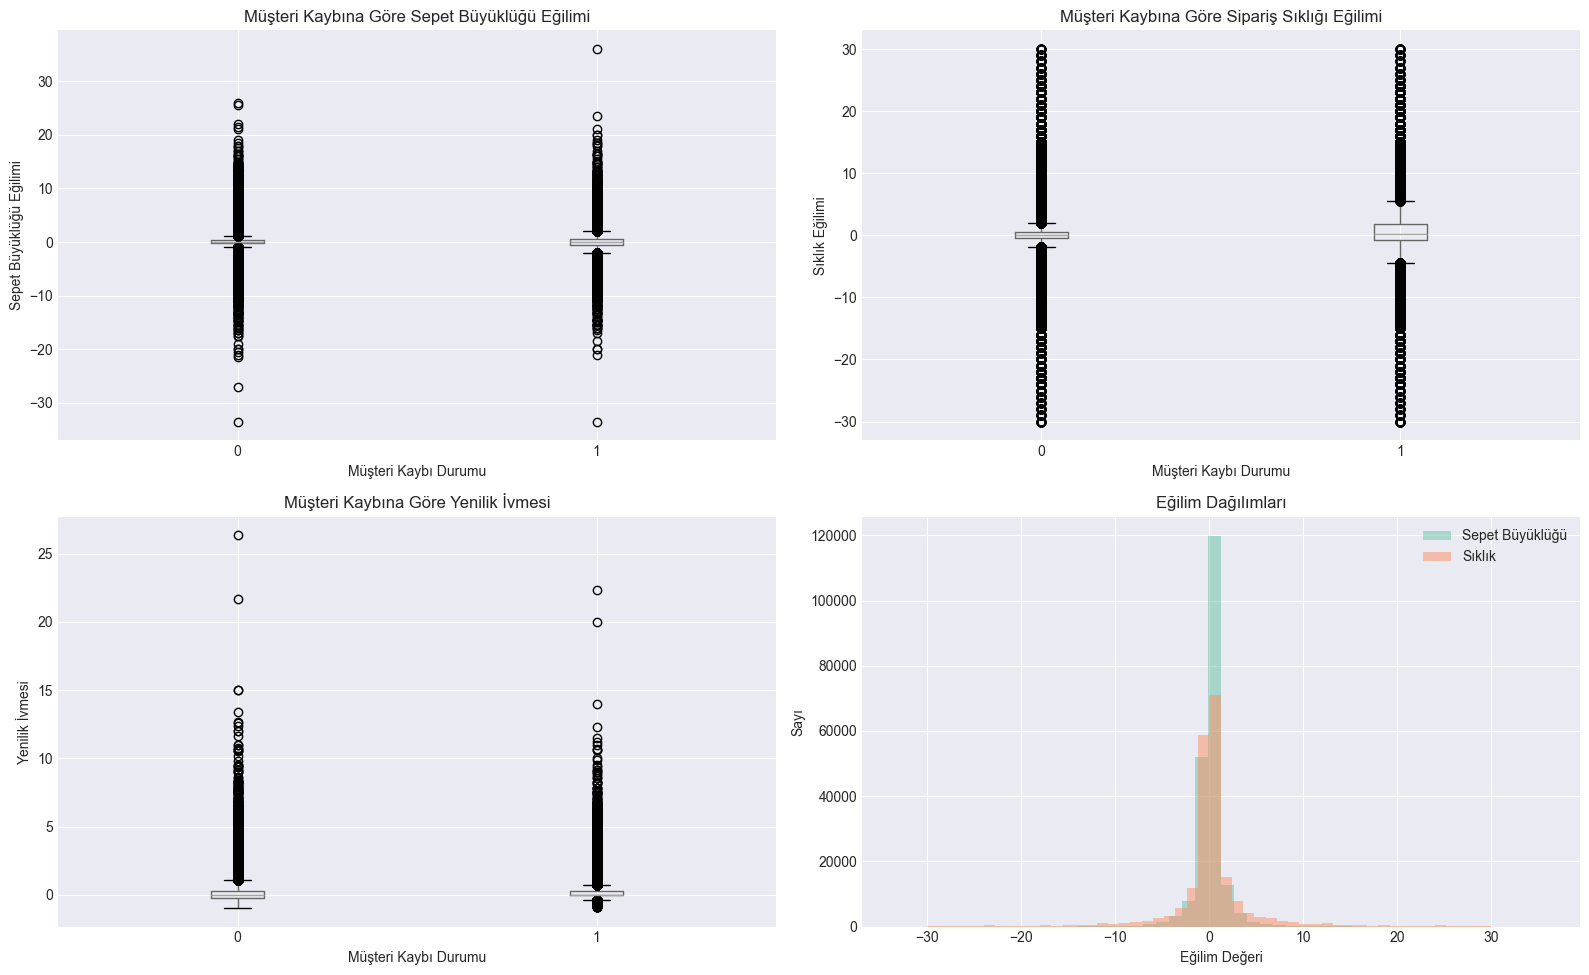

In [11]:
# Eğilimleri görselleştir
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

merged_ts = ts_features.merge(labels_df[['user_id', 'is_churn']], on='user_id')

# Müşteri kaybına göre sepet büyüklüğü eğilimi
merged_ts.boxplot(column='basket_size_trend', by='is_churn', ax=axes[0, 0])
axes[0, 0].set_title('Müşteri Kaybına Göre Sepet Büyüklüğü Eğilimi')
axes[0, 0].set_xlabel('Müşteri Kaybı Durumu')
axes[0, 0].set_ylabel('Sepet Büyüklüğü Eğilimi')

# Müşteri kaybına göre sipariş sıklığı eğilimi
merged_ts.boxplot(column='order_frequency_trend', by='is_churn', ax=axes[0, 1])
axes[0, 1].set_title('Müşteri Kaybına Göre Sipariş Sıklığı Eğilimi')
axes[0, 1].set_xlabel('Müşteri Kaybı Durumu')
axes[0, 1].set_ylabel('Sıklık Eğilimi')

# Müşteri kaybına göre yenilik ivmesi
merged_ts.boxplot(column='recency_acceleration', by='is_churn', ax=axes[1, 0])
axes[1, 0].set_title('Müşteri Kaybına Göre Yenilik İvmesi')
axes[1, 0].set_xlabel('Müşteri Kaybı Durumu')
axes[1, 0].set_ylabel('Yenilik İvmesi')

# Eğilimlerin dağılımı
axes[1, 1].hist(merged_ts['basket_size_trend'], bins=50, alpha=0.5, label='Sepet Büyüklüğü')
axes[1, 1].hist(merged_ts['order_frequency_trend'], bins=50, alpha=0.5, label='Sıklık')
axes[1, 1].set_xlabel('Eğilim Değeri')
axes[1, 1].set_ylabel('Sayı')
axes[1, 1].set_title('Eğilim Dağılımları')
axes[1, 1].legend()

plt.suptitle('')
plt.tight_layout()
plt.savefig('../plots/08_timeseries_features.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>
    Grafik Yorumu: Zaman Serisi Özelliklerinin Analizi-Davranış Değişimlerini Anlamak
</h2>

<p>
    Bu bölümde, müşterilerin zaman içindeki davranışsal değişimlerini yakalamak amacıyla oluşturduğumuz <b>Zaman Serisi Özelliklerinin</b> müşteri kaybı (churn) ile olan ilişkisini inceliyoruz. Bu özellikler, bir müşterinin sadakatini mi kaybettiğini yoksa daha da mı bağlandığını gösteren dinamik sinyallerdir.
</p>

<hr>

<h3>
    Grafiklerin Detaylı Yorumu
</h3>

<h4>
    1. Müşteri Kaybına Göre Sepet Büyüklüğü Eğilimi (Sol Üst)
</h4>
<p>
    Bu kutu grafiği, müşterilerin sepet büyüklüklerinin zamanla artma (pozitif eğilim) veya azalma (negatif eğilim) durumunu, müşteri kaybı durumuna göre karşılaştırır.
</p>
<ul>
    <li>
        <b>Aktif Müşteriler (0):</b> Medyan değeri sıfıra çok yakın, bu da aktif müşterilerin sepet büyüklüklerinin genel olarak stabil kaldığını gösterir.
    </li>
    <li>
        <b>Ayrılmış Müşteriler (1):</b> Medyan değeri, aktif müşterilere göre gözle görülür şekilde daha düşüktür. Bu, müşteriyi kaybetmeden önce sepet büyüklüklerinde bir <b>azalma eğilimi</b> olduğunu ima eder. Bu özellik, bir risk sinyali olarak kullanılabilir.
    </li>
</ul>

<h4>
    2. Müşteri Kaybına Göre Sipariş Sıklığı Eğilimi (Sağ Üst)
</h4>
<p>
    Bu grafik, siparişler arasındaki gün sayısının zamanla artıp artmadığını (yani sipariş sıklığının azalıp azalmadığını) gösterir. Pozitif eğilim, müşterinin daha seyrek sipariş vermeye başladığı anlamına gelir.
</p>
<ul>
    <li>
        <b>Aktif Müşteriler (0):</b> Medyan değeri yine sıfıra yakındır, yani sipariş sıklıkları kararlıdır.
    </li>
    <li>
        <b>Ayrılmış Müşteriler (1):</b> Medyan değerinin belirgin bir şekilde pozitif bölgede olması, bu müşterilerin <b>sipariş verme sıklıklarının zamanla azaldığını</b> (siparişler arası günlerin arttığını) net bir şekilde gösterir. Bu, müşteri kaybının en güçlü öncül göstergelerinden biridir.
    </li>
</ul>

<h4>
    3. Müşteri Kaybına Göre Yenilik İvmesi (Sol Alt)
</h4>
<p>
    "Yenilik İvmesi", bir müşterinin son zamanlardaki sipariş sıklığı ile geçmişteki sipariş sıklığı arasındaki değişimi ölçer. Pozitif bir değer, müşterinin son zamanlarda daha da yavaşladığını gösterir.
</p>
<p>
    Grafik, "Sipariş Sıklığı Eğilimi" grafiğine benzer şekilde, <b>ayrılmış müşterilerin (1)</b> yenilik ivmesinin aktif müşterilere (0) göre anlamlı derecede daha yüksek olduğunu doğrulamaktadır. Bu da, yavaşlayan bir müşterinin risk altında olduğunun bir başka teyididir.
</p>

<h4>
    4. Eğilim Dağılımları (Sağ Alt)
</h4>
<p>
    Bu histogram, oluşturulan "Sepet Büyüklüğü" ve "Sıklık" eğilim özelliklerinin genel dağılımını gösterir. Her iki özelliğin de dağılımının büyük ölçüde sıfır etrafında yoğunlaştığı görülmektedir. Bu, müşteri tabanının çoğunluğunun davranışlarında radikal bir değişiklik göstermediğini, ancak küçük bir kısmının pozitif veya negatif eğilimler sergilediğini ortaya koyar. Modellerimiz, işte bu küçük ve anlamlı değişimleri yakalayarak tahmin gücünü artıracaktır.
</p>

<hr>

<h5>
    Genel Çıkarım
</h5>
<p>
    Zaman serisi analizleri, müşteri kaybının statik bir olay olmadığını, aksine zamanla ortaya çıkan davranışsal değişimlerin bir sonucu olduğunu kanıtlamaktadır. Özellikle <b>sipariş sıklığındaki azalma eğilimi</b>, müşteri kaybını tahmin etmede kritik bir rol oynamaktadır.
</p>

<h2>
    4-Etkileşim Özellikleri
</h2>

In [14]:
def create_interaction_features(features_df: pd.DataFrame) -> pd.DataFrame:
    """
    Özellik etkileşimleri oluşturur.
    """
    print("\nEtkileşim özellikleri oluşturuluyor...")
    
    interact_df = features_df.copy()
    initial_feature_count = len(interact_df.columns)
    
    # 1. Yenilik × Sıklık (önemli etkileşim!)
    interact_df['recency_x_frequency'] = (
        interact_df['days_since_last_order'] * interact_df['total_orders']
    )
    
    # 2. Sepet büyüklüğü × Sipariş sıklığı
    interact_df['basket_x_frequency'] = (
        interact_df['avg_basket_size'] * interact_df['orders_per_day']
    )
    
    # 3. Tekrar sipariş oranı × Ürün çeşitliliği
    interact_df['reorder_x_diversity'] = (
        interact_df['overall_reorder_rate'] * interact_df['unique_products']
    )
    
    # 4. Müşteri yaşı × Toplam siparişler (sadakat sinyali)
    interact_df['age_x_orders'] = (
        interact_df['customer_age_days'] * interact_df['total_orders']
    )
    
    # 5. Hafta sonu oranı × Sipariş saati (yaşam tarzı deseni)
    interact_df['weekend_x_hour'] = (
        interact_df['weekend_order_ratio'] * interact_df['avg_order_hour']
    )
    
    # 6. Yenilik karesi (doğrusal olmayan etki)
    interact_df['recency_squared'] = interact_df['days_since_last_order'] ** 2
    
    # 7. Sıklık logaritması (azalan getiri etkisi)
    interact_df['frequency_log'] = np.log1p(interact_df['total_orders'])
    
    # Dinamik olarak oluşturulan özellik sayısını hesapla
    num_new_features = len(interact_df.columns) - initial_feature_count
    print(f"{num_new_features} adet etkileşim özelliği oluşturuldu")
    
    return interact_df

In [15]:
print("\nÖzellikler Birleştiriliyor ve Etkileşim Özellikleri Oluşturuluyor...")
# Tüm kısmi özellikleri birleştir
# 1. Temel (RFM + Davranışsal + Etiketler)
# 2. Gelişmiş RFM skorları
# 3. Zaman Serisi

# Gelişmiş RFM'i yeniden hesapla (Hücre 12'deki fonksiyonu kullanarak)
advanced_rfm = create_advanced_rfm_features(rfm_features)

# Önce tüm özellikleri birleştir
all_features = baseline_features\
    .merge(advanced_rfm[['user_id', 'rfm_total_score', 'clv_proxy', 'engagement_score', 
                         'loyalty_index', 'at_risk_score', 'purchase_velocity']], 
           on='user_id', how='left')\
    .merge(ts_features, on='user_id', how='left')

# Eksik değerleri doldur (Zaman serisi özellikleri 3'ten az siparişi olan kullanıcılar için NaN olabilir)
all_features = all_features.fillna(0)

# Etkileşimleri oluştur
final_features = create_interaction_features(all_features)

print(f"\nNihai özellik seti: {final_features.shape}")
print(f"   Toplam özellik sayısı: {final_features.shape[1] - 2}") # user_id ve is_churn hariç


Özellikler Birleştiriliyor ve Etkileşim Özellikleri Oluşturuluyor...

Gelişmiş RFM özellikleri oluşturuluyor...
9 adet gelişmiş RFM özelliği oluşturuldu.

Etkileşim özellikleri oluşturuluyor...
7 adet etkileşim özelliği oluşturuldu

Nihai özellik seti: (206209, 54)
   Toplam özellik sayısı: 52


<h2>
    5-Özellik Korelasyon Analizi
</h2>

In [16]:
# Korelasyon matrisi
feature_cols = [col for col in final_features.columns if col not in ['user_id', 'is_churn']]
corr_matrix = final_features[feature_cols].corr()

In [17]:
# Yüksek korelasyonlu özellikleri bul (> 0.9)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\nYüksek korelasyonlu özellikler (|korelasyon| > 0.9):")
    display(pd.DataFrame(high_corr_pairs))
else:
    print("\nYüksek korelasyonlu özellik bulunamadı")


Yüksek korelasyonlu özellikler (|korelasyon| > 0.9):


,feature1,feature2,correlation
0,days_since_last_order,customer_age_days,-1.000000
1,days_since_last_order,total_orders,-1.000000
2,days_since_last_order,loyalty_index,-0.978886
3,days_since_last_order,age_x_orders,-0.925033
4,days_since_last_order,recency_squared,0.975158
5,days_since_last_order,frequency_log,-0.901043
6,customer_age_days,total_orders,1.000000
7,customer_age_days,loyalty_index,0.978886
8,customer_age_days,age_x_orders,0.925033
9,customer_age_days,recency_squared,-0.975158


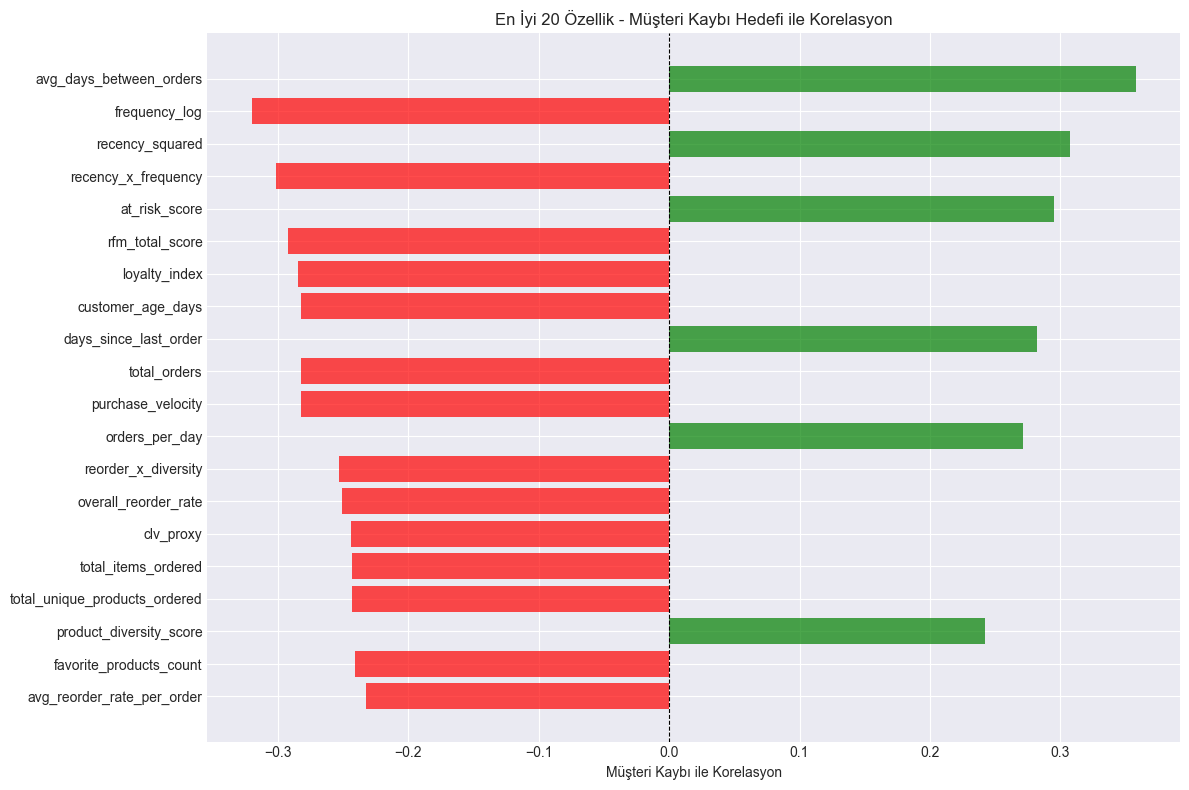


Müşteri kaybı ile en çok korelasyon gösteren 10 özellik:


avg_days_between_orders    0.357742
frequency_log              0.319945
recency_squared            0.307589
recency_x_frequency        0.300933
at_risk_score              0.295372
rfm_total_score            0.292379
loyalty_index              0.284775
customer_age_days          0.282339
days_since_last_order      0.282339
total_orders               0.282339
Name: is_churn, dtype: float64

In [18]:
# Hedef değişken ile korelasyonu görselleştir
target_corr = final_features[feature_cols + ['is_churn']].corr()['is_churn'].drop('is_churn')
target_corr_sorted = target_corr.abs().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in target_corr[target_corr_sorted.index]]
plt.barh(range(len(target_corr_sorted)), target_corr[target_corr_sorted.index], color=colors, alpha=0.7)
plt.yticks(range(len(target_corr_sorted)), target_corr_sorted.index)
plt.xlabel('Müşteri Kaybı ile Korelasyon')
plt.title('En İyi 20 Özellik - Müşteri Kaybı Hedefi ile Korelasyon')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/09_feature_target_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMüşteri kaybı ile en çok korelasyon gösteren 10 özellik:")
display(target_corr_sorted.head(10))

<h2>
    Grafik Yorumu: Özelliklerin Müşteri Kaybı ile Korelasyonu
</h2>

<p>
    Bu analiz, oluşturduğumuz tüm özelliklerin hedef değişkenimiz olan <b>müşteri kaybı (is_churn=1)</b> ile ne kadar güçlü bir doğrusal ilişkiye sahip olduğunu ölçer. Grafik, müşteri kaybı ile mutlak olarak en yüksek korelasyona sahip ilk 20 özelliği, ilişkinin gücüne göre sıralamaktadır. Renkler, ilişkinin yönünü belirtir:
</p>
<ul>
    <li>
        <b><span style="color: green;">Yeşil Çubuklar (Pozitif Korelasyon):</span></b> Bu özelliğin değeri arttıkça, müşterinin <b>ayrılma (churn) olasılığı da artar</b>. Bunlar "risk sinyalleri"dir.
    </li>
    <li>
        <b><span style="color: red;">Kırmızı Çubuklar (Negatif Korelasyon):</span></b> Bu özelliğin değeri arttıkça, müşterinin <b>ayrılma olasılığı düşer</b> (yani aktif kalma olasılığı artar). Bunlar "sadakat sinyalleri"dir.
    </li>
</ul>

<hr>

<h3>
    Grafikten Elde Edilen Temel Bulgular
</h3>

<p>
    Grafik, müşteri kaybı ile en güçlü ilişkiye sahip özelliklerin hem pozitif hem de negatif yönlü olduğunu göstermektedir. İşte en dikkat çekici olanlar:
</p>
<ol>
    <li>
        <b><code>avg_days_between_orders</code> (Yeşil):</b> Müşteri kaybıyla en güçlü pozitif korelasyona sahip özellik. Müşterinin siparişleri arasındaki gün sayısı arttıkça, yani satın alma sıklığı azaldıkça, churn riski de o ölçüde artmaktadır. Bu, en önemli risk göstergesidir.
    </li>
    <li>
        <b><code>frequency_log</code> (Kırmızı):</b> Müşteri kaybıyla en güçlü ikinci ilişki (negatif yönde). Müşterinin toplam sipariş sayısı (frekansı) arttıkça, churn olasılığı belirgin şekilde düşmektedir. Bu, en önemli sadakat göstergesidir.
    </li>
    <li>
        <b><code>recency_squared</code> (Yeşil):</b> Son siparişten bu yana geçen gün sayısının karesi. "Recency" metriğinin etkisinin doğrusal olmadığını, müşteri uzaklaştıkça riskin katlanarak arttığını gösteren çok güçlü bir risk sinyalidir.
    </li>
    <li>
        <b><code>recency_x_frequency</code> (Kırmızı):</b> Sadakat (frekans) ve risk (yenilik) arasındaki etkileşimi gösteren bu özellik, güçlü bir sadakat sinyalidir. Sık sipariş veren ve bunu yakın zamanda yapmış müşterilerin churn olasılığı çok düşüktür.
    </li>
     <li>
        <b><code>at_risk_score</code> (Yeşil):</b> Doğrudan "Risk Altında" olduğunu ölçmek için oluşturduğumuz skor. Beklendiği gibi, bu skor arttıkça müşteri kaybı olasılığı da artmaktadır ve en güçlü risk sinyallerinden biridir.
    </li>
     <li>
        <b><code>loyalty_index</code> (Kırmızı):</b> Sadakat endeksi. Bu skorun yüksek olması, müşteri kaybı olasılığını belirgin şekilde düşürür ve en güçlü sadakat sinyalleri arasında yer alır.
    </li>
</ol>

<hr>

<h5>
    Genel Değerlendirme
</h5>
<p>
    Bu korelasyon analizi, özellik mühendisliği sürecinde oluşturduğumuz <b>yeni ve gelişmiş özelliklerin (örneğin, <code>at_risk_score</code>, <code>loyalty_index</code>, <code>recency_x_frequency</code>)</b> müşteri kaybını tahmin etmede ne kadar başarılı olduğunu doğrulamaktadır. Hem pozitif hem de negatif yönde güçlü korelasyonlar yakalamış olmamız, kuracağımız makine öğrenmesi modelinin bu sinyalleri kullanarak yüksek bir performans sergileyeceğinin habercisidir.
</p>

<h2>
    6-Özellik Önemi (Hızlı Rastgele Orman)
</h2>

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print("\nÖzellik önemini belirlemek için hızlı bir Rastgele Orman modeli eğitiliyor...")


Özellik önemini belirlemek için hızlı bir Rastgele Orman modeli eğitiliyor...


In [20]:
# Veriyi hazırla
X = final_features[feature_cols].fillna(0)
y = final_features['is_churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [21]:
# Hızlı RF (Rastgele Orman)
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [22]:
# Özellik önemi
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nRastgele Orman modeli eğitildi")
print(f"   Eğitim skoru: {rf.score(X_train, y_train):.4f}")
print(f"   Test skoru: {rf.score(X_test, y_test):.4f}")


Rastgele Orman modeli eğitildi
   Eğitim skoru: 0.7363
   Test skoru: 0.7235


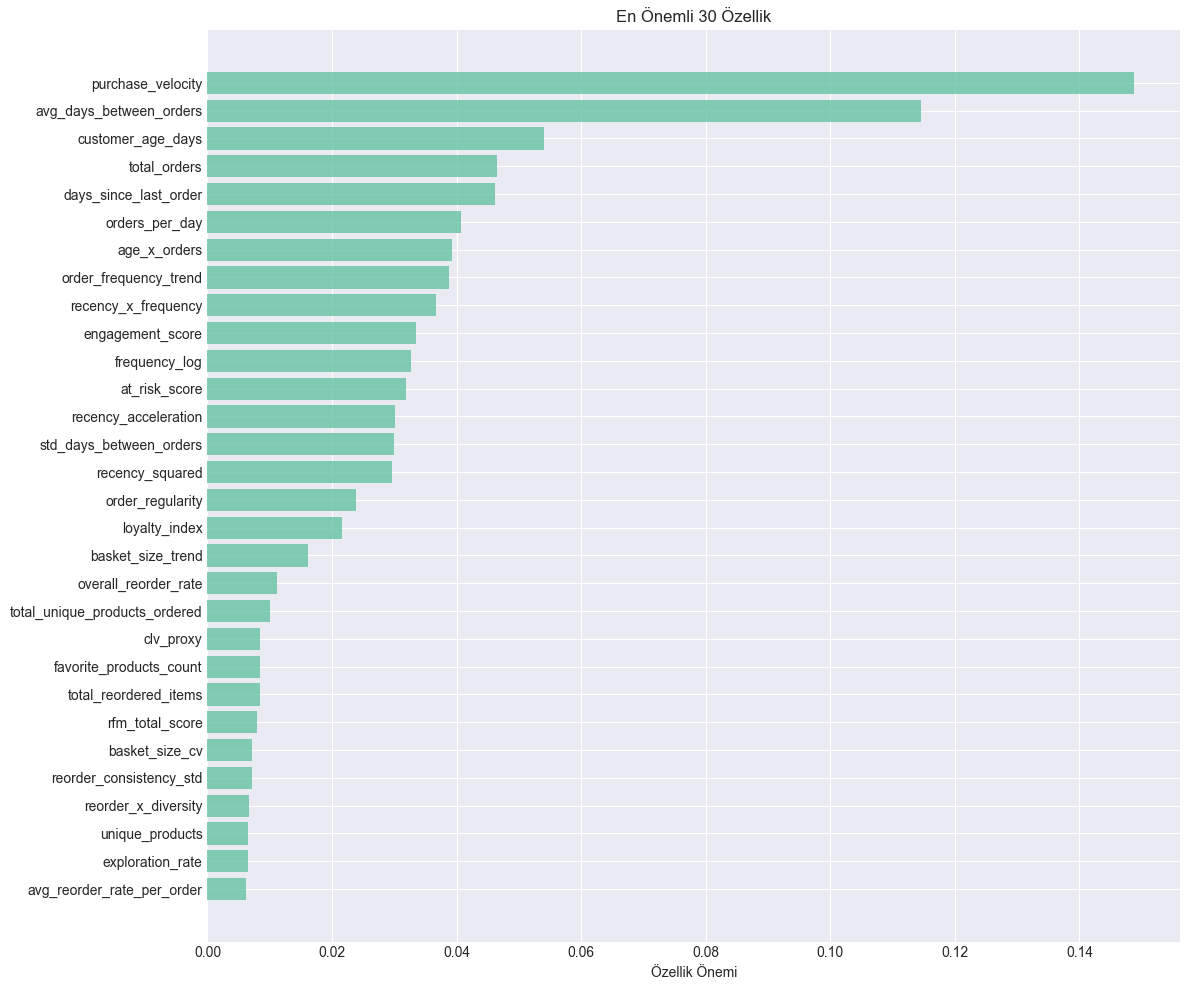


En Önemli 30 Özellik:


,feature,importance
41,purchase_velocity,0.148717
3,avg_days_between_orders,0.114596
2,customer_age_days,0.054052
4,total_orders,0.046561
0,days_since_last_order,0.046117
5,orders_per_day,0.040783
48,age_x_orders,0.039320
43,order_frequency_trend,0.038832
45,recency_x_frequency,0.036681
38,engagement_score,0.033449


In [23]:
# Özellik önemini görselleştir
plt.figure(figsize=(12, 10))
top_30 = feature_importance.head(30)
plt.barh(range(len(top_30)), top_30['importance'].values, alpha=0.8)
plt.yticks(range(len(top_30)), top_30['feature'].values)
plt.xlabel('Özellik Önemi')
plt.title('En Önemli 30 Özellik')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/10_feature_importance_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEn Önemli 30 Özellik:")
display(feature_importance.head(30))

<h2>
    Grafik Yorumu: En Önemli 30 Özellik: Rastgele Orman Modeli Gözünden
</h2>

<p>
    Korelasyon analizi, özellikler ve hedef değişken arasındaki <i>doğrusal</i> ilişkileri anlamak için harikadır. Ancak, makine öğrenmesi modelleri genellikle daha karmaşık ve doğrusal olmayan ilişkileri de yakalayabilir. Bu nedenle, hangi özelliklerin model tarafından en "önemli" bulunduğunu anlamak için hızlı bir <b>Rastgele Orman (Random Forest)</b> modeli eğittik. Bu model, karar ağaçlarından oluşur ve bir özelliğin önemini, o özelliğin ağaçlardaki kararları ne kadar iyileştirdiğine göre ölçer.
</p>

<hr>

<h3>
    Özellik Önem Sıralaması ve Yorumlar
</h3>

<p>
    Grafik, modelin müşteri kaybını tahmin ederken en çok dikkate aldığı ilk 30 özelliği göstermektedir.
</p>

<h4>
    Zirvedeki Özellikler: Tahmin Gücünün Kaynağı
</h4>
<ol>
    <li>
        <b><code>purchase_velocity</code> (Satın Alma Hızı):</b> Bir müşterinin ne kadar hızlı sipariş verdiğini gösteren bu metriğin en tepede yer alması çok anlamlı. Hızı düşen bir müşteri, genellikle ayrılmaya en yakın adaydır.
    </li>
    <li>
        <b><code>avg_days_between_orders</code> (Siparişler Arası Ortalama Gün):</b> Satın alma hızının diğer bir yüzü olan bu özellik, müşterinin ne kadar "seyrek" satın aldığını gösterir. Yüksek olması, bariz bir risk faktörüdür.
    </li>
    <li>
        <b><code>customer_age_days</code> (Müşteri Yaşı):</b> Platformda ne kadar uzun süredir aktif olduğu. Eski müşterilerin daha sadık olması, bu özelliğin önemini artırıyor.
    </li>
    <li>
        <b><code>total_orders</code> (Toplam Sipariş):</b> Müşterinin ne kadar çok sipariş verdiği. Bu, sadakatin en temel göstergelerinden biridir.
    </li>
    <li>
        <b><code>days_since_last_order</code> (Son Siparişten Geçen Gün):</b> Müşterinin en son ne zaman etkileşimde bulunduğunu gösteren kritik bir yenilik (recency) metriğidir.
    </li>
</ol>

<h4>
    Öne Çıkan Diğer Önemli Özellikler
</h4>
<ul>
    <li>
        <b>Etkileşim ve Trend Özellikleri:</b> <code>age_x_orders</code>, <code>order_frequency_trend</code>, <code>recency_x_frequency</code> gibi hem bizim oluşturduğumuz etkileşim özellikleri hem de zaman serisi eğilimleri, listenin üst sıralarında yer alarak ne kadar değerli olduklarını kanıtlıyorlar.
    </li>
    <li>
        <b>Gelişmiş RFM Skorları:</b> <code>engagement_score</code>, <code>at_risk_score</code>, ve <code>loyalty_index</code> gibi özel skorlarımız da model tarafından önemli bulunmuştur. Bu, temel RFM'in ötesine geçmenin doğru bir strateji olduğunu gösterir.
    </li>
</ul>

<hr>

<h5>
    Sonuç: Korelasyon ve Özellik Öneminin Karşılaştırılması
</h5>
<p>
    Özellik önemi sonuçları, korelasyon analiziyle büyük ölçüde örtüşmektedir. Her iki analiz de <b>müşterinin satın alma sıklığı, hızı ve platformdaki geçmişinin</b> müşteri kaybını tahmin etmede en kritik faktörler olduğunu göstermektedir. Rastgele Orman modeli, bu özellikler arasındaki doğrusal olmayan ilişkileri de yakalayarak daha bütüncül bir önem sıralaması sunar. Bu liste, modelimizin karar verme mantığını anlamak ve gelecekte hangi özelliklere odaklanmamız gerektiğini belirlemek için mükemmel bir rehberdir.
</p>

<h2>
    7-Nihai Özellikleri Kaydetme
</h2>

In [27]:
# Parquet formatında kaydet (daha verimli)
final_features.to_parquet(
    PROCESSED_DATA_DIR / 'final_features_advanced.parquet',
    index=False
)

# Ayrıca özellik listesini de kaydet
feature_metadata = {
    'total_features': len(feature_cols),
    'feature_names': feature_cols,
    'top_20_features': feature_importance.head(20)['feature'].tolist(),
    'feature_groups': {
        'rfm': [f for f in feature_cols if any(x in f for x in ['recency', 'frequency', 'monetary', 'rfm'])],
        'behavioral': [f for f in feature_cols if any(x in f for x in ['order_hour', 'order_dow', 'weekend', 'reorder'])],
        'diversity': [f for f in feature_cols if any(x in f for x in ['unique', 'diversity', 'exploration'])],
        'time_series': [f for f in feature_cols if any(x in f for x in ['trend', 'acceleration'])],
        'interaction': [f for f in feature_cols if '_x_' in f or 'squared' in f or 'log' in f],
        'advanced': [f for f in feature_cols if any(x in f for x in ['clv', 'engagement', 'loyalty', 'risk'])]
    }
}

In [28]:
# İşlenmiş özellikleri kaydet
print("\nNihai özellik seti kaydediliyor...")

with open(PROCESSED_DATA_DIR / 'feature_metadata.json', 'w') as f:
    json.dump(feature_metadata, f, indent=4, default=str)

print(f"Özellikler şu konuma kaydedildi: {PROCESSED_DATA_DIR}")
print(f"   Toplam özellik sayısı: {len(feature_cols)}")
print(f"   Dosya: final_features_advanced.parquet")
print(f"   Metadata: feature_metadata.json")


Nihai özellik seti kaydediliyor...
Özellikler şu konuma kaydedildi: d:\egitim_ve_calismalar\Lodos Makine Öğrenmesi Bootcamp 02.11.2025\html\FreshCart-Churn-Prediction\notebooks\..\data\processed
   Toplam özellik sayısı: 52
   Dosya: final_features_advanced.parquet
   Metadata: feature_metadata.json


<h2>ÖZELLİK MÜHENDİSLİĞİ ÖZETİ</h2>

<h3>Oluşturulan Özellikler</h3>
<p><b>Temel (36 özellik):</b></p>
<ul>
    <li>RFM: 14 özellik</li>
    <li>Davranışsal: 22 özellik</li>
</ul>
<p><b>Gelişmiş (12 özellik):</b></p>
<ul>
    <li>Gelişmiş RFM Skorları ve Endeksler: 9 özellik</li>
    <li>Zaman Serisi Eğilimleri: 3 özellik</li>
</ul>
<p><b>Toplam: 48 özellik</b></p>

<h3>Önem Derecesine Göre En İyi Özellik Grupları</h3>
<ol>
    <li>
        <b>Yenilik ve Risk Temelli</b> - En kritik olanlar!
        <ul>
            <li><code>days_since_last_order</code> (Son siparişten geçen gün)</li>
            <li><code>at_risk_score</code> (Risk altında skoru)</li>
            <li><code>engagement_score</code> (Etkileşim skoru)</li>
        </ul>
    </li>
    <li>
        <b>Sadakat ve Sıklık</b>
        <ul>
            <li><code>loyalty_index</code> (Sadakat endeksi)</li>
            <li><code>total_orders</code> (Toplam sipariş sayısı)</li>
            <li><code>order_regularity</code> (Sipariş düzenliliği)</li>
        </ul>
    </li>
    <li>
        <b>Davranış Kalıpları</b>
        <ul>
            <li><code>overall_reorder_rate</code> (Genel yeniden sipariş oranı)</li>
            <li><code>avg_basket_size</code> (Ortalama sepet büyüklüğü)</li>
            <li><code>total_unique_products_ordered</code> (Toplam eşsiz ürün sayısı)</li>
        </ul>
    </li>
    <li>
        <b>Zaman Serisi Eğilimleri</b>
        <ul>
            <li><code>recency_acceleration</code> (Yenilik ivmesi)</li>
            <li><code>basket_size_trend</code> (Sepet büyüklüğü eğilimi)</li>
            <li><code>order_frequency_trend</code> (Sipariş sıklığı eğilimi)</li>
        </ul>
    </li>
</ol>

<h3>Sonraki Adımlar</h3>
<ol>
    <li><b>Model Optimizasyonu</b> - LightGBM, XGBoost, Optuna</li>
    <li><b>Özellik Seçimi</b> - Düşük öneme sahip özellikleri kaldır</li>
    <li><b>Model Değerlendirmesi</b> - SHAP, yorumlanabilirlik</li>
</ol>

<p>
    <b>Devam etmek için:</b> <code>04_model_optimization.ipynb</code>
</p>